<a href="https://colab.research.google.com/github/Pooret/jokes/blob/main/jokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# custom functions
from utils import evaluate_model, populate_pos_class

### Read-in and explore the dataset

In [2]:
# extract the data
df = pd.read_csv('https://query.data.world/s/htrdsouy327xqa4w457qx6k6sjtj6r')

In [3]:
# examine the data
df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,ftbp1i,2qh72,jokes,False,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i...,self.jokes,NaN,My corona is covered with foreskin so it is no...,I am soooo glad I'm not circumcised!,2
1,post,ftboup,2qh72,jokes,False,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup...,self.jokes,NaN,It's called Google Sheets.,Did you know Google now has a platform for rec...,9
2,post,ftbopj,2qh72,jokes,False,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj...,self.jokes,NaN,The vacuum doesn't snore after sex.\n\n&amp;#x...,What is the difference between my wife and my ...,15
3,post,ftbnxh,2qh72,jokes,False,1585785428,https://old.reddit.com/r/Jokes/comments/ftbnxh...,self.jokes,NaN,[removed],My last joke for now.,9
4,post,ftbjpg,2qh72,jokes,False,1585785009,https://old.reddit.com/r/Jokes/comments/ftbjpg...,self.jokes,NaN,[removed],The Nintendo 64 turns 18 this week...,134


In [4]:
df.shape

(1000000, 12)

In [5]:
df['score'].describe()

count    1000000.000000
mean         139.691119
std         1674.046005
min            0.000000
25%            0.000000
50%            1.000000
75%            7.000000
max       142733.000000
Name: score, dtype: float64

In [6]:
# define some parameters 
CLASS_SIZE = len(df[df['score'] == 0]) // 3
TRAIN_SIZE = 0.95
#MIN_UPVOTES = 1000

In [7]:
# boolean masks

# where selftext isnull (no punchline)
is_null = df['selftext'].isnull()

# where title or post were removed by reddit user/mod
removed = (df['selftext'] == '[removed]') | (df['title'] == '[removed]')

# where tile or post were deleted by the original poster
deleted = (df['selftext'] == '[deleted]') | (df['title'] == '[deleted]')

# where upvotes is 0 (reddit automatically provides user 1 upvote)
neg_class = df['score'] == 0

In [8]:
# get entries that aren't removed or deleted
df_cleaned = df[~removed][~deleted]
df_cleaned.shape

(578634, 12)

In [9]:
# Filter entries that are short, but meet other necessary criteria
# # remove unnecessary whitespace 
df_cleaned[['selftext', 'title']] = df_cleaned[['selftext', 'title']].applymap(lambda x:" ".join(str(x).split()))
df_cleaned['selftext_len'] = df_cleaned['selftext'].str.len()
df_cleaned['title_len'] = df_cleaned['title'].str.len()

# boolean masks
title_window = (df_cleaned['title_len'] > 0) & (df_cleaned['title_len'] < 500)
selftext_window = (df_cleaned['selftext_len'] > 0) & (df_cleaned['selftext_len'] < 500)

# apply masks to filter
df_cleaned = df_cleaned[selftext_window & title_window]
print(f"{len(df_cleaned[~neg_class])} samples match")

409626 samples match


In [10]:
# returns boolean mask and updated_class sizes for binary classification.
# boolean mask is for instances in the positive class that meet arguments

pos_class_mask, updated_class_size = populate_pos_class(df_cleaned, 5, 1500, CLASS_SIZE)

100%|██████████| 1495/1495 [00:36<00:00, 40.52it/s]

WARNING, CURRENT PARAMETERS RESULT IN CLASS SIZE REDUCTION
desired size 87126
current size 86259


### Make the positive and negative class labels and concatenate the dataframe

In [11]:
# create target label
df_cleaned['target'] = pos_class_mask
df_concat = pd.concat([df_cleaned[neg_class].sample(updated_class_size), df_cleaned[pos_class_mask]], axis=0)
df_concat.groupby('target').describe()['score']

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
False,86259.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
True,86259.0,1144.099781,4771.478846,28.0,46.0,92.0,283.0,142733.0


### Examine Timeseries Data

In [12]:
# making unix created_times into readable timestamps
def make_tz_timestamp(unix_ts, tz='US/Eastern'):
    from datetime import datetime
    import pytz
    timezone = pytz.timezone(tz)
    # convert unix utc to timestamp utc
    ts = datetime.utcfromtimestamp(unix_ts)
    # return is to that it is tz-aware
    #return timezone.localize(ts)
    return ts

df_concat['created_at'] = df_concat['created_utc'].apply(lambda x: make_tz_timestamp(x))
df_concat[['created_at', 'title', 'selftext', 'target']].head()

,created_at,title,selftext,target
890768,2016-02-26 18:52:44,The coolest letter.,Why is N the coolest letter? Because it's N.Ice,False
454692,2018-02-26 22:24:42,I’ve seen online that you can get 20 .223 Remi...,It means I can take my wife and her three kids...,False
11730,2020-03-17 18:32:09,Coronavirus,New meaning of batshit crazy,False
121082,2019-09-13 17:50:51,2 penguins are canoeing in the desert,"One says: ""where's the paddle"" Other says: ""It...",False
859780,2016-05-21 01:22:58,"What goes up a chimney down, but won't go down...",An umbrella!,False


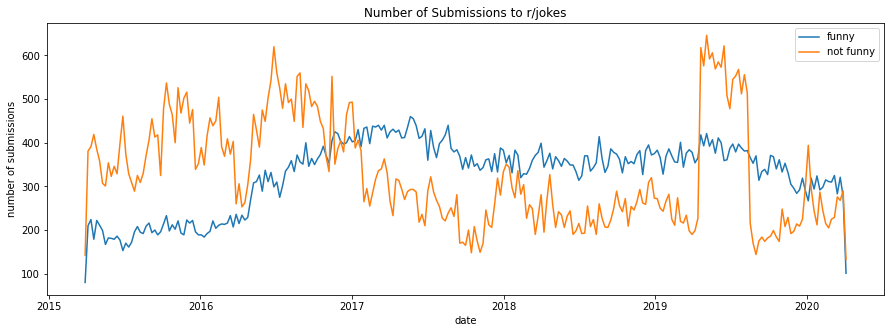

In [13]:
# plot submissions
plt.figure(figsize=(15, 5))
data_good = df_concat[df_concat['target']==True].set_index('created_at', drop=True).resample('W').count()
data_bad = df_concat[df_concat['target']==False].set_index('created_at', drop=True).resample('W').count()
sns.lineplot(x=data_good.index, y='type', data=data_good, label='funny')
sns.lineplot(x=data_bad.index, y='type', data=data_bad, label='not funny')
plt.title('Number of Submissions to r/jokes')
plt.xlabel('date')
plt.ylabel('number of submissions')
plt.legend()
plt.show()

### Split into train/test

In [14]:
# prepare the dataframe
training_size = int(len(df_concat)*TRAIN_SIZE)
df_concat_shuffled = df_concat.sample(len(df_concat)).reset_index(drop=True)
df_concat_shuffled['selftext'] = df_concat_shuffled['selftext'].fillna(value='emptypunchline')
train = df_concat_shuffled[:training_size]
test = df_concat_shuffled[training_size:]
print(train.shape, test.shape)

(163892, 16) (8626, 16)


### Text Preprocessing

In [15]:
import re
import spacy
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprec

In [16]:
# def clean_text(text):

#   import re
#   links = r"(https?)\S+"
#   html_encodings = r"(\&amp;|#x200B;)"
#   possessive_contractions = r"(\'|'|')"

#   text = re.sub(links, 'urllink', text)
#   text = re.sub(html_encodings, ' ', text)
#   text = re.sub(possessive_contractions, '', text)
#   return text

def preprocess(text):
  result = []
  for token in gensim.utils.simple_preprocess(text, deacc=True):
      result.append(token)
  return result

In [17]:
train['all_text'] = train['title'] + " " + train['selftext']
#train['processed'] = train['all_text'].apply(lambda x: clean_text(x))
train['processed'] = train['all_text'].apply(lambda x: preprocess(x))

### Topic Modeling

In [18]:
funny_df = train[train['target'] == True]
not_funny_df = train[train['target'] == False]

processed_funny = funny_df['processed'].tolist()
processed_not_funny = not_funny_df['processed'].tolist()

funny_dictionary = gensim.corpora.Dictionary(processed_funny)
not_funny_dictionary = gensim.corpora.Dictionary(processed_not_funny)

In [19]:
# bigram and trigram models
bigram_funny = gensim.models.Phrases(processed_funny, min_count=5, threshold=100)
bigram_not_funny = gensim.models.Phrases(processed_not_funny, min_count=5, threshold=100)

trigram_funny = gensim.models.Phrases(bigram_funny[processed_funny], threshold=100)
trigram_not_funny = gensim.models.Phrases(bigram_not_funny[processed_not_funny], threshold=100)

In [20]:
!python3 -m spacy download en_core_web_lg

2022-08-15 19:03:17.194297: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 7.6 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [24]:
bigram_mod_funny = gensim.models.phrases.Phraser(bigram_funny)
bigram_mod_not_funny = gensim.models.phrases.Phraser(bigram_not_funny)

trigram_mod_funny = gensim.models.phrases.Phraser(trigram_funny)
trigam_mod_not_funny = gensim.models.phrases.Phraser(trigram_not_funny)


nlp = spacy.load('en_core_web_lg')

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
  return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts, trigram_mod, bigram_mod):
  return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN', 'SYM', 'NUM', 'AUX', 'ADP']):
  texts_out = []
  for sent in tqdm(texts):
    doc = nlp(" ".join(sent))
    texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return texts_out



In [25]:
processed_funny_nostops = remove_stopwords(processed_funny)
processed_funny_bigrams = make_bigrams(processed_funny_nostops, bigram_mod_funny)
processed_funny_lemmatized = lemmatization(processed_funny_bigrams)
id2word_funny = gensim.corpora.Dictionary(processed_funny_lemmatized)

funny_texts = processed_funny_lemmatized
funny_corpus = [id2word_funny.doc2bow(text) for text in funny_texts]

100%|██████████| 81950/81950 [13:15<00:00, 103.02it/s]


In [26]:
processed_not_funny_nostops = remove_stopwords(processed_not_funny)
processed_not_funny_bigrams = make_bigrams(processed_not_funny_nostops, bigram_mod_not_funny)
processed_not_funny_lemmatized = lemmatization(processed_not_funny_bigrams)
id2word_not_funny = gensim.corpora.Dictionary(processed_not_funny_lemmatized)

not_funny_texts = processed_not_funny_lemmatized
not_funny_corpus = [id2word_not_funny.doc2bow(text) for text in not_funny_texts]

100%|██████████| 81942/81942 [12:42<00:00, 107.44it/s]


In [ ]:
# Bag of Words
funny_dictionary.filter_extremes(no_below=5, no_above=0.5)
funny_bow_corpus = [funny_dictionary.doc2bow(doc) for doc in processed_funny]

In [ ]:
not_funny_dictionary.filter_extremes(no_below=5, no_above=0.5)
not_funny_bow_corpus = [not_funny_dictionary.doc2bow(doc) for doc in processed_not_funny]

In [ ]:
len(funny_dictionary)

8224

In [ ]:
len(not_funny_dictionary)

9112

In [ ]:
from gensim import corpora, models
funny_vect = models.TfidfModel(funny_bow_corpus)
funny_tfidf = funny_vect[funny_bow_corpus]
funny_lda_model = gensim.models.LdaMulticore(funny_bow_corpus, num_topics=20, id2word=funny_dictionary, passes=2, workers=2)

In [ ]:
for idx, topic in funny_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.027*"job" + 0.021*"get" + 0.014*"differ" + 0.012*"fire" + 0.012*"letter" + 0.011*"lose" + 0.009*"fart" + 0.009*"happi" + 0.008*"know" + 0.008*"condom"
Topic: 1 
Words: 0.061*"bar" + 0.058*"say" + 0.057*"walk" + 0.039*"drink" + 0.032*"bartend" + 0.032*"guy" + 0.020*"priest" + 0.019*"beer" + 0.018*"ask" + 0.016*"order"
Topic: 2 
Words: 0.062*"like" + 0.018*"cow" + 0.018*"red" + 0.015*"say" + 0.015*"eat" + 0.013*"look" + 0.013*"women" + 0.012*"eye" + 0.010*"john" + 0.008*"blue"
Topic: 3 
Words: 0.038*"joke" + 0.022*"good" + 0.021*"like" + 0.014*"funni" + 0.014*"hear" + 0.012*"men" + 0.012*"guy" + 0.011*"gay" + 0.011*"engin" + 0.011*"work"
Topic: 4 
Words: 0.036*"boy" + 0.026*"say" + 0.025*"mom" + 0.023*"ask" + 0.020*"mother" + 0.019*"kid" + 0.018*"girl" + 0.015*"bear" + 0.015*"littl" + 0.013*"day"
Topic: 5 
Words: 0.028*"car" + 0.022*"play" + 0.019*"cop" + 0.017*"say" + 0.014*"drive" + 0.013*"go" + 0.013*"hors" + 0.013*"park" + 0.011*"pull" + 0.011*"know"
Topic: 6 
Word

In [ ]:
funny_lda_model.log_perplexity(funny_bow_corpus)

-7.910358956372687

In [ ]:
funny_coherence_model = CohereModel(model=funny_lda_model, texts = )

In [ ]:
not_funny_vect = models.TfidfModel(not_funny_bow_corpus)
not_funny_tfidf = not_funny_vect[not_funny_bow_corpus]
not_funny_lda_model = gensim.models.LdaMulticore(not_funny_bow_corpus, num_topics=20, id2word=not_funny_dictionary, passes=2, workers=2)

In [ ]:
for idx, topic in not_funny_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.032*"eat" + 0.016*"dick" + 0.015*"differ" + 0.015*"god" + 0.012*"pay" + 0.011*"win" + 0.010*"million" + 0.009*"obama" + 0.009*"go" + 0.008*"jam"
Topic: 1 
Words: 0.031*"year" + 0.029*"chicken" + 0.029*"cross" + 0.027*"wife" + 0.026*"sex" + 0.025*"road" + 0.021*"friend" + 0.019*"old" + 0.018*"teacher" + 0.014*"say"
Topic: 2 
Words: 0.078*"trump" + 0.058*"knock" + 0.041*"donald" + 0.024*"nan" + 0.015*"joke" + 0.013*"nazi" + 0.012*"number" + 0.012*"afraid" + 0.011*"polic" + 0.010*"orang"
Topic: 3 
Words: 0.020*"blond" + 0.013*"hair" + 0.012*"state" + 0.012*"eleph" + 0.012*"peopl" + 0.011*"laugh" + 0.011*"fact" + 0.010*"go" + 0.010*"cut" + 0.008*"hand"
Topic: 4 
Words: 0.025*"game" + 0.015*"line" + 0.013*"play" + 0.012*"fli" + 0.012*"hear" + 0.009*"high" + 0.009*"food" + 0.009*"video" + 0.009*"smoke" + 0.008*"pick"
Topic: 5 
Words: 0.023*"job" + 0.016*"news" + 0.014*"work" + 0.012*"bird" + 0.012*"glass" + 0.011*"joke" + 0.010*"new" + 0.010*"eat" + 0.010*"get" + 0.009*"po

In [ ]:
from sklearn.feature_selection import chi2 as x2

y = train['target']
X_names = cv.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = x2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

NameError: name 'cv' is not defined

In [ ]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# False:
  . selected features: 3595
  . top features: and,apparently,asked,asked me,but,call,dad,did,did the,do
 
# True:
  . selected features: 3595
  . top features: and,apparently,asked,asked me,but,call,dad,did,did the,do
 


### Examine Text Metadata 

In [ ]:
train.columns

Index(['type', 'id', 'subreddit.id', 'subreddit.name', 'subreddit.nsfw',
       'created_utc', 'permalink', 'domain', 'url', 'selftext', 'title',
       'score', 'selftext_len', 'title_len', 'target', 'created_at'],
      dtype='object')

In [ ]:
# train['selftext_len'] = train['selftext'].str.len()
# train['title_len'] = train['title'].str.len()

<ipython-input-43-9a0f1ece748d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['log_title_len'] = np.log(train['title_len'])


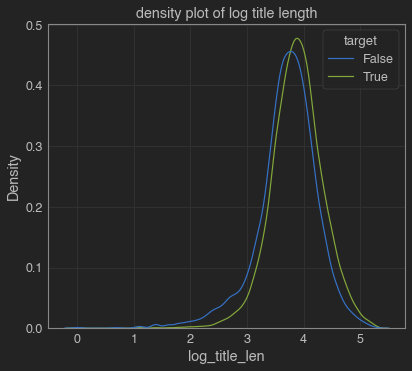

<ipython-input-43-9a0f1ece748d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['log_selftext_len'] = np.log(train['selftext_len'])


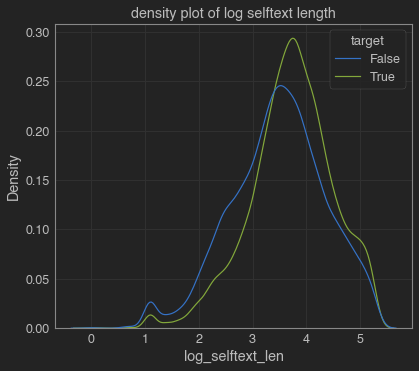

In [ ]:
train['log_title_len'] = np.log(train['title_len'])
sns.kdeplot(x='log_title_len', data=train, hue='target')
plt.title('density plot of log title length')
plt.show()
train['log_selftext_len'] = np.log(train['selftext_len'])
sns.kdeplot(x='log_selftext_len', data=train, hue='target')
plt.title('density plot of log selftext length')
plt.show()

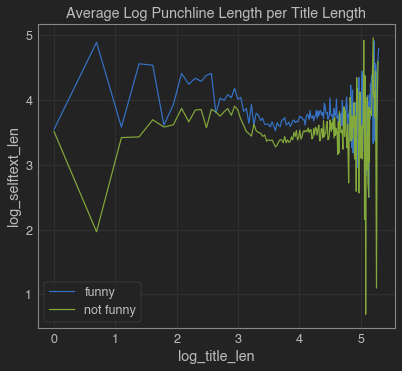

In [ ]:
# title length



sns.lineplot(x='log_title_len', y='log_selftext_len', data = funny_df.groupby('log_title_len', as_index=False).mean(), label='funny')
sns.lineplot(x='log_title_len', y='log_selftext_len', data = not_funny_df.groupby('log_title_len', as_index=False).mean(), label='not funny')
plt.legend()
plt.title('Average Log Punchline Length per Title Length')
plt.show()

# sns.histplot(x='target', data=train.groupby('title_len').mean(), color='red')
# plt.title('Average Target Boolean per Title Length')

Text(0.5, 1.0, 'variation of length')

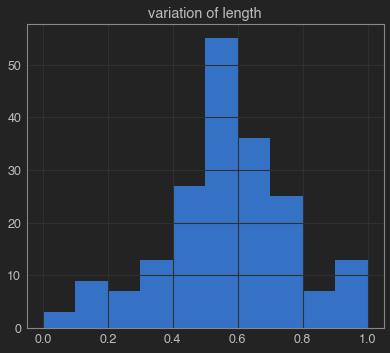

In [ ]:
train.groupby(['title_len']).mean()['target'].hist()
plt.title('variation of length')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

classifier = MultinomialNB()
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

corpus = list(train['all_text'])
X_train = vectorizer.fit_transform(corpus)
y_train = train['target']
X_val = vectorizer.transform(list(val['all_text']))
y_val = val['target']

In [ ]:
model = Pipeline([('vectorizer', vectorizer),
                  ('classifier', classifier)])

model.fit(train['all_text'], train['target'])

predict = model.predict(val['all_text'])
predicted_prob = model.predict_proba(val['all_text'])

Accuracy: 0.68
Auc: 0.68
Detail:
              precision    recall  f1-score   support

       False       0.67      0.71      0.69      1995
        True       0.69      0.66      0.67      2001

    accuracy                           0.68      3996
   macro avg       0.68      0.68      0.68      3996
weighted avg       0.68      0.68      0.68      3996



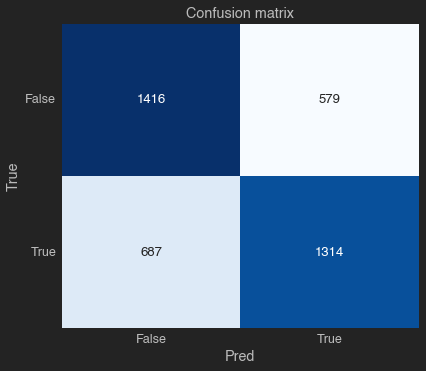

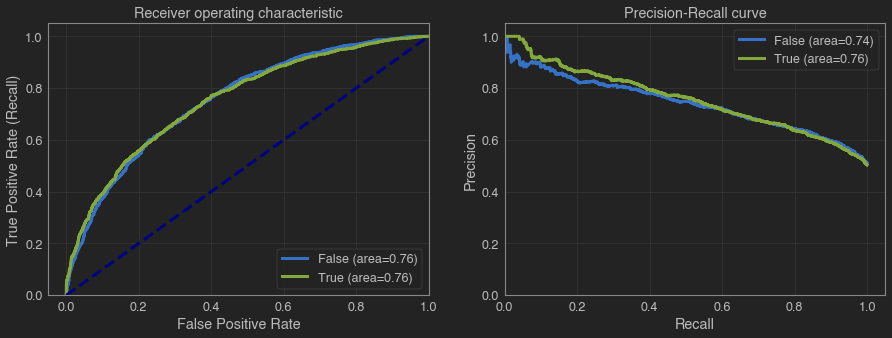

In [ ]:
evaluate_model(val['target'], predict, predicted_prob)

In [ ]:
tokenized_title = train['title'].apply(lambda x:x.split())

import gensim

model_w2v = gensim.models.Word2Vec(
    tokenized_title,
    # dimension (feature numbers)
    vector_size=300,
    # size of context window
    window = 10,
    min_count=2,
    sg = 1,
    hs = 0,
    negative = 10,
    workers = 2,
)
model_w2v.train(tokenized_title, total_examples=len(train['title']), epochs=20)

(5016757, 6955300)

In [ ]:
for word in top_funny_words:
    print(word, '\n')
    most_similar_words = model_w2v.wv.most_similar(positive=f'{word}')
    for sim_word, score in most_similar_words:
        print(f"     {sim_word}: {score}")
    print('.....')

NameError: name 'top_funny_words' is not defined

In [ ]:
for word in top_notfunny_words:
    print(word, '\n')
    most_similar_words = model_w2v.wv.most_similar(positive=f'{word}')
    for sim_word, score in most_similar_words:
        print(f"     {sim_word}: {score}")
    print('.....')

NameError: name 'top_notfunny_words' is not defined

In [ ]:
# selftext length
sns.lineplot(x='selftext_len', y='title_len', data = funny_df.groupby('selftext_len', as_index=False).mean(), label='funny')
sns.lineplot(x='selftext_len', y='title_len', data = notfunny_df.groupby('selftext_len', as_index=False).mean(), label='not funny')
plt.legend()
plt.title('Average Title Length per Punchline Length')
plt.show()

# sns.histplot(x='target', data=train.groupby('title_len').mean(), color='red')
# plt.title('Average Target Boolean per Title Length')

In [ ]:
train.groupby(['selftext_len']).mean()['target'].hist()
plt.title('variation of length')

In [ ]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(train['selftext'].astype(str))

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

frequency = pd.DataFrame(words_freq, columns = ['word', 'freq'])

frequency.head(30).sort_values(by='freq').plot(x='word', y='freq', kind='barh',color='orange')
plt.title('all words')

In [ ]:
cv_funny = CountVectorizer(stop_words='english')
words = cv_funny.fit_transform(funny_df['selftext'].astype(str))
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv_funny.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

funny_frequency = pd.DataFrame(words_freq, columns = ['word', 'freq'])

funny_frequency.head(30).sort_values(by='freq').plot(x='word', y='freq', kind='barh')
plt.title('funny')

In [ ]:
cv_notfunny = CountVectorizer(stop_words='english')
words = cv_notfunny.fit_transform(notfunny_df['selftext'].astype(str))
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv_notfunny.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

notfunny_frequency = pd.DataFrame(words_freq, columns = ['word', 'freq'])

notfunny_frequency.head(30).sort_values(by='freq').plot(x='word', y='freq', kind='barh', color='green')
plt.title('not funny')

In [ ]:
# funny words
top_funny_words = list(set(funny_frequency['word'].head(10)).difference(set(notfunny_frequency['word'].head(10))))
top_notfunny_words = list(set(notfunny_frequency['word'].head(10)).difference(set(funny_frequency['word'].head(10))))

In [ ]:
top_funny_words

In [ ]:
top_notfunny_words

In [ ]:
tokenized_selftext = train['selftext'].apply(lambda x:str(x).lower().split())

import gensim

model_w2v_punchline = gensim.models.Word2Vec(
    tokenized_selftext,
    # dimension (feature numbers)
    vector_size=200,
    # size of context window
    window = 10,
    min_count=2,
    sg = 1,
    hs = 0,
    negative = 10,
    workers = 2,
)
model_w2v_punchline.train(tokenized_title, total_examples=len(train['selftext']), epochs=20)

In [ ]:
for word in top_funny_words:
    print(word, '\n')
    most_similar_words = model_w2v.wv.most_similar(positive=f'{word}')
    for sim_word, score in most_similar_words:
        print(f"     {sim_word}: {score}")
    print('.....')

In [ ]:
for word in top_notfunny_words:
    print(word, '\n')
    most_similar_words = model_w2v.wv.most_similar(positive=f'{word}')
    for sim_word, score in most_similar_words:
        print(f"     {sim_word}: {score}")
    print('.....')

In [ ]:
# def sample_jokes(dataframe, num_jokes=10, tokenize=False):
#     if tokenize:
#         for i in range(num_jokes):
#             joke = train[['title', 'selftext', 'target']].sample(1)
#             print(f'Joke #{i+1}')
#             print(joke['title'].iloc[0].split(' '))
#             print('.....................')
#             print(joke['selftext'].iloc[0].split(' '))
#             print('Is It Funny? ----> ', joke['target'].iloc[0])
#             print('\n')
        
#     for i in range(num_jokes):
#         joke = train[['title', 'selftext', 'target']].sample(1)
#         print(f'Joke #{i+1}')
#         print(joke['title'].iloc[0])
#         print('.....................')
#         print(joke['selftext'].iloc[0])
#         print('Is It Funny? ----> ', joke['target'].iloc[0])
#         print('\n')
# sample_jokes(train, 10, tokenize=True)

In [ ]:
# funny_words = []
# for i, row in funny_df[['title', 'selftext']].iterrows():
#     funny_words_title = [word for word in row['title'].split()]
#     funny_words.append(funny_words_title)
#     funny_words_selftext = [word for word in row['selftext'].split()]
#     funny_words.append(funny_words_selftext)
    
# funny_words_vocab = set(funny_words)

# not_funny_words = []
# for i, row in not_funny_df[['title', 'selftext']].iterrows():
#     not_funny_words_title = [word for word in row['title'].split()]
#     not_funny_words.append(not_funny_words_title)
#     not_funny_words_selftext = [word for word in row['selftext'].split()]
#     not_funny_words.append(not_funny_words_selftext)
    
# not_funny_words_vocab = set(not_funny_words)

TypeError: unhashable type: 'list'

In [ ]:
# # unique words 
# from sklearn.feature_extraction.text import CountVectorizer

# cv_funny = CountVectorizer(stop_words=None)
# cv_not_funny = CountVectorizer(stop_words=None)

# cv_funny.fit_transform(funny_df['title'])
# cv_not_funny.fit_transform(not_funny_df['title'])
# funny_words = set(cv_funny.vocabulary_.keys())
# not_funny_words = set(cv_not_funny.vocabulary_.keys())
# # get unique words that are only in funny/not funny entries
# funny_words_title = list((funny_words).difference(not_funny_words))
# not_funny_words_title = list((not_funny_words).difference(funny_words))
# # funny_words_selftext = list(set(funny_frequency['selftext']).difference(set(notfunny_frequency['selftext'])))
# # not_funny_words_selftext = list(set(notfunny_frequency['selftext']).difference(set(funny_frequency['selftext'])))
# cv_funny.fit_transform(funny_df['selftext'])
# cv_not_funny.fit_transform(not_funny_df['selftext'])
# funny_words = set(cv_funny.vocabulary_.keys())
# not_funny_words = set(cv_not_funny.vocabulary_.keys())
# # get unique words that are only in funny/not funny entries
# funny_words_selftext = list((funny_words).difference(not_funny_words))
# not_funny_words_selftext = list((not_funny_words).difference(funny_words))

In [ ]:
# cv_funny_title = CountVectorizer(stop_words=None, vocabulary = funny_words_title)
# cv_funny_selftext = CountVectorizer(stop_words=None, vocabulary = funny_words_selftext)
# words_title = cv_funny_title.fit_transform(funny_df['title'])
# words_selftext = cv_funny_selftext.fit_transform(funny_df['selftext'])
# sum_words_title = words_title.sum(axis=0)
# sum_words_selftext = words_selftext.sum(axis=0)

# words_freq_title = [(word, sum_words[0, i]) for word, i in cv_funny_titles.vocabulary_.items()]
# words_freq_title = sorted(words_freq_title, key = lambda x: x[1], reverse=True)
# words_freq_selftext = [(word, sum_words[0, i]) for word, i in cv_funny_selftext.vocabulary_.items()]
# words_freq_selftext = sorted(words_freq_selftext, key = lambda x: x[1], reverse=True)

# funny_frequency_title = pd.DataFrame(words_freq_title, columns = ['word', 'freq'])
# funny_frequency_selftext = pd.DataFrame(words_freq_selftext, columns = ['word', 'freq'])

# funny_frequency_title.head(30).sort_values(by='freq').plot(x='word', y='freq', kind='barh')
# funny_frequency_selftext.head(30).sort_values(by='freq').plot(x='word', y='freq', kind='barh')
# plt.title('Most Common Words that are only in funny titles')
# plt.show()

In [ ]:
# cv_not_funny_title = CountVectorizer(stop_words=None, vocabulary = not_funny_words_title)
# cv_not_funny_selftext = CountVectorizer(stop_words=None, vocabulary = not_funny_words_selftext)
# words_title = cv_not_funny_title.fit_transform(funny_df['title'])
# words_selftext = cv_not_funny_selftext.fit_transform(funny_df['selftext'])
# sum_words_title = words_title.sum(axis=0)
# sum_words_selftext = words_selftext.sum(axis=0)

# words_freq_title = [(word, sum_words[0, i]) for word, i in cv_not_funny_title.vocabulary_.items()]
# words_freq_title = sorted(words_freq_title, key = lambda x: x[1], reverse=True)
# words_freq_selftext = [(word, sum_words[0, i]) for word, i in cv_not_funny_selftext.vocabulary_.items()]
# words_freq_selftext = sorted(words_freq_selftext, key = lambda x: x[1], reverse=True)

# funny_frequency_title = pd.DataFrame(words_freq_title, columns = ['word', 'freq'])
# funny_frequency_selftext = pd.DataFrame(words_freq_selftext, columns = ['word', 'freq'])

# funny_frequency_title.head(30).sort_values(by='freq').plot(x='word', y='freq', kind='barh')
# funny_frequency_selftext.head(30).sort_values(by='freq').plot(x='word', y='freq', kind='barh')
# plt.title('Most Common Words that are only in funny titles')
# plt.show()

In [ ]:
# def plot_window_size_by_output(freq_table_a, freq_table_b, min_window_size=1, max_window_size=10000):
#     from tqdm import tqdm
#     num_elements_freq_a = []
#     window_sizes = []
    
#     for window_size in tqdm(range(min_window_size, max_window_size + 1)):
#         elements_only_in_a = list(set(freq_table_a['word'].head(window_size)).difference(set(freq_table_b['word'].head(window_size))))
#         elements_only_in_b = list(set(freq_table_b['word'].head(window_size)).difference(set(freq_table_a['word'].head(window_size))))
        
#         num_elements_freq_a.append(len(elements_only_in_a))
#         window_sizes.append(window_size)
        
#     sns.lineplot(x = window_sizes, y=num_elements_freq_a, color='blue')
#     plt.xlabel('window sizes')
#     plt.ylabel('number of unique words')
#     plt.show()


In [ ]:
# df_dt = df_concat.set_index('created_at', drop=True).sort_index()
# # get difference in time and find relative frequency from the lag
# res = (pd.Series(df_dt.index[1:]) - pd.Series(df_dt.index[:-1])).value_counts()
# full_rng = pd.date_range(df_dt.index[0], df_dt.index[-1], freq=res.index[0])

#TODO look at reading level
- vocab
- statistical correlations
- probability tests
- Topic Modeling for filtering
- Stopwords include/not include
- Check stopwords, add stop words
- humor types: dark, dry, crass humor, NSFW (audience type)
- joke similarity (clustering)